In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#random forest
# Importing necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import pandas as pd
from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean

from sklearn.model_selection import train_test_split
from skimage import data, color, feature
from skimage.feature import hog

import glob

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
import seaborn as sns

In [3]:
# Function to load image data and labels(Train/Test)
def load_data(manhole, tipo):
    label = []
    arr = []
    strr = "/content/drive/MyDrive/Manhole detection/Man_hole_DB/"+manhole+"/"+tipo+"/*"
    for file_ in glob.glob(strr):
        # Read the image, convert it to RGB, and add it to the list
        img = cv2.imread(file_)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        arr.append(img)
        # Add the corresponding label to the label list
        label.append(manhole)
    return arr, label

In [4]:

# Function to load the entire training or test dataset
def whole_train_data(tipo):
    # Load data and labels for each category (Closed, Open, Road)
    closed_data, closed_label = load_data('Closed', tipo)
    open_data, open_label = load_data('Open', tipo)
    road_data, road_label = load_data('Road', tipo)
    # Concatenate data and labels for all categories
    data = np.concatenate((closed_data, open_data, road_data))
    labels = np.concatenate((closed_label, open_label, road_label))
    return data, labels

In [5]:
# Load the entire training dataset
data_train, labels_train = whole_train_data('Train')
# Load the entire test dataset
data_test, labels_test = whole_train_data('Test')
print("Training data shape:", data_train.shape)
print("Training labels shape:", labels_train.shape)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Training data shape: (3715,)
Training labels shape: (3715,)


In [6]:
# Function to preprocess images by converting to grayscale and resizing
def preprocessing(arr):
    arr_prep = []
    for i in range(arr.shape[0]):
        # Convert each image to grayscale
        img = cv2.cvtColor(arr[i], cv2.COLOR_BGR2GRAY)
        # Resize the image to a fixed size (72x72) using skimage's resize
        img = resize(img, (72, 72), anti_aliasing=True)
        arr_prep.append(img)
    return arr_prep

In [7]:
# Preprocess the training data and test data
data_train_p = np.array(preprocessing(data_train))
data_test_p = np.array(preprocessing(data_test))
print("Preprocessed training data shape:", data_train_p.shape)


Preprocessed training data shape: (3715, 72, 72)


In [8]:
# Function to extract HOG features from an image
def ExtractHOG(img):
    ftr, _ = hog(img, orientations=8, pixels_per_cell=(16, 16),
                 cells_per_block=(1, 1), visualize=True, multichannel=False)
    return ftr

In [9]:
# Function to preprocess the data by extracting HOG features
def preprocessing_part_two(arr):
    arr_feature = []
    for i in range(np.shape(arr)[0]):
        arr_feature.append(ExtractHOG(arr[i]))
    return arr_feature

In [10]:
# Preprocess the training and test data by extracting HOG features
data_train_ftr = preprocessing_part_two(data_train_p)
data_test_ftr = preprocessing_part_two(data_test_p)

<ipython-input-8-52a879650543>:3: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ftr, _ = hog(img, orientations=8, pixels_per_cell=(16, 16),


In [11]:
# Create and train the Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(data_train_ftr, labels_train)

RandomForestClassifier()

In [12]:
# Predict the labels for the test data and calculate accuracy
y_pred = random_forest.predict(data_test_ftr)
accuracy = accuracy_score(labels_test, y_pred)
print('Test Accuracy:', accuracy*100, "%")

Test Accuracy: 68.09571286141576 %


In [13]:
# Calculate the F1 score
f1 = f1_score(labels_test, y_pred, average='weighted')
print('F1 Score:', f1)

F1 Score: 0.6785922367850653


In [14]:
# Create a classification report to show precision, recall, and F1 score for each class
class_names = np.unique(labels_test)
print('Classification Report:')
print(classification_report(labels_test, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

      Closed       0.66      0.73      0.69       380
        Open       0.66      0.74      0.70       363
        Road       0.80      0.53      0.64       260

    accuracy                           0.68      1003
   macro avg       0.70      0.67      0.67      1003
weighted avg       0.69      0.68      0.68      1003



In [15]:
# Create a confusion matrix
conf_matrix = confusion_matrix(labels_test, y_pred)

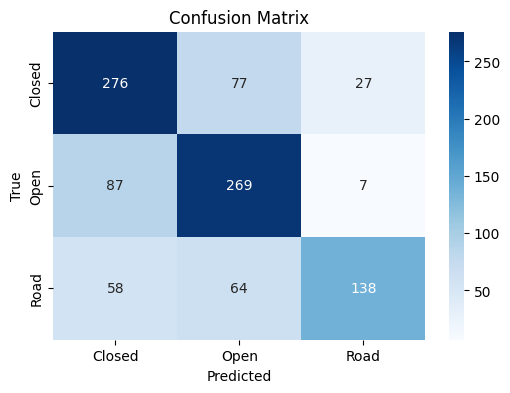

In [16]:

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

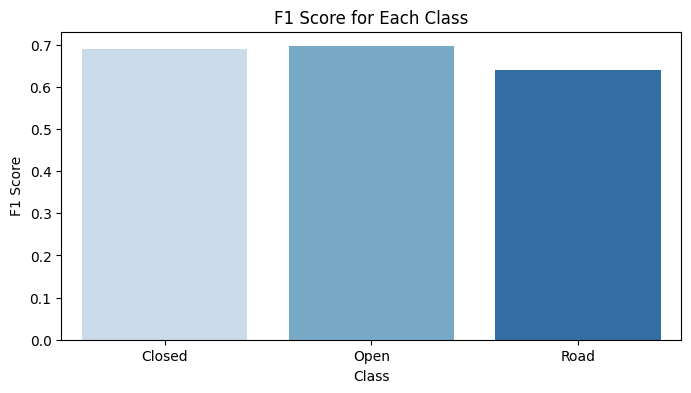

In [17]:
# Create a bar plot to show the F1 score for each class
f1_scores = f1_score(labels_test, y_pred, average=None)
plt.figure(figsize=(8, 4))
sns.barplot(x=class_names, y=f1_scores, palette='Blues')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Score for Each Class')
plt.show()